In [1]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import GroupKFold

In [2]:
image_size = (128, 128)
batch_size = 32
epochs = 50

In [3]:
def load_data(images_path, labels_path):
    X, y, groups = [], [], []
    labels_set = set()
    for label_file in os.listdir(labels_path):
        if label_file.endswith('.txt'):
            label_path = os.path.join(labels_path, label_file)
            folder_num = label_file.split('.')[0]
            image_folder = os.path.join(images_path, folder_num)
            if os.path.exists(image_folder):
                with open(label_path, 'r') as f:
                    labels = f.read().strip().split(',')
                    labels_set.update(labels)
                    for image_file in os.listdir(image_folder):
                        if image_file.endswith('.png'):
                            image_path = os.path.join(image_folder, image_file)
                            image = load_img(image_path, target_size=image_size)
                            image = img_to_array(image) / 255.0
                            X.append(image)
                            y.append(labels)
                            groups.append(folder_num)

    label_to_index = {label: index for index, label in enumerate(labels_set)}
    y_encoded = np.zeros((len(y), len(label_to_index)))
    for i, labels in enumerate(y):
        for label in labels:
            y_encoded[i, label_to_index[label]] = 1

    X = np.array(X)
    y_encoded = np.array(y_encoded)
    groups = np.array(groups)

    return X, y_encoded, groups, label_to_index

In [4]:
def combine_datasets(X1, y1, groups1, label_to_index1, X2, y2, groups2, label_to_index2):
    all_labels = sorted(set(label_to_index1.keys()).union(label_to_index2.keys()))
    label_to_index_combined = {label: index for index, label in enumerate(all_labels)}

    def convert_labels(y, label_to_index_old, label_to_index_new):
        y_new = np.zeros((y.shape[0], len(label_to_index_new)))
        for old_label, old_index in label_to_index_old.items():
            if old_label in label_to_index_new:
                new_index = label_to_index_new[old_label]
                y_new[:, new_index] = y[:, old_index]
        return y_new

    y1_combined = convert_labels(y1, label_to_index1, label_to_index_combined)
    y2_combined = convert_labels(y2, label_to_index2, label_to_index_combined)

    X_combined = np.concatenate((X1, X2), axis=0)
    y_combined = np.concatenate((y1_combined, y2_combined), axis=0)
    groups_combined = np.concatenate((groups1, groups2), axis=0)

    return X_combined, y_combined, groups_combined, label_to_index_combined

In [5]:
images_path1 = 'sadovaya-mebel2/images'
labels_path1 = 'sadovaya-mebel2/labels'
images_path2 = 'osveshchenie/images'
labels_path2 = 'osveshchenie/labels'

X1, y1, groups1, label_to_index1 = load_data(images_path1, labels_path1)
X2, y2, groups2, label_to_index2 = load_data(images_path2, labels_path2)

In [6]:
X_combined, y_combined, groups, label_to_index= combine_datasets(X1, y1, groups1, label_to_index1, X2, y2, groups2, label_to_index2)

print('X_combined shape:', X_combined.shape)
print('y_combined shape:', y_combined.shape)
print('label_to_index_combined:', label_to_index)

X_combined shape: (562, 128, 128, 3)
y_combined shape: (562, 62)
label_to_index_combined: {'apple': 0, 'bed': 1, 'bench': 2, 'book': 3, 'bottle': 4, 'bowl': 5, 'building-other-merged': 6, 'cabinet-merged': 7, 'ceiling-merged': 8, 'chair': 9, 'clock': 10, 'couch': 11, 'cup': 12, 'curtain': 13, 'dining table': 14, 'dirt-merged': 15, 'donut': 16, 'door-stuff': 17, 'fence-merged': 18, 'floor-other-merged': 19, 'floor-wood': 20, 'flower': 21, 'fork': 22, 'grass-merged': 23, 'gravel': 24, 'handbag': 25, 'house': 26, 'keyboard': 27, 'knife': 28, 'laptop': 29, 'light': 30, 'mirror-stuff': 31, 'mountain-merged': 32, 'mouse': 33, 'orange': 34, 'pavement-merged': 35, 'person': 36, 'pillow': 37, 'potted plant': 38, 'rock-merged': 39, 'roof': 40, 'rug-merged': 41, 'sea': 42, 'shelf': 43, 'skateboard': 44, 'sky-other-merged': 45, 'spoon': 46, 'stairs': 47, 'table-merged': 48, 'towel': 49, 'tree-merged': 50, 'tv': 51, 'umbrella': 52, 'vase': 53, 'wall-brick': 54, 'wall-other-merged': 55, 'wall-stone'

In [7]:
group_kfold = GroupKFold(n_splits=5)
train_idx, test_idx = next(group_kfold.split(X_combined, y_combined, groups))

X_train, X_test = X_combined[train_idx], X_combined[test_idx]
y_train, y_test = y_combined[train_idx], y_combined[test_idx]

In [28]:
# model = Sequential([
#     Conv2D(256, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3), padding='same', strides=1),
#     MaxPooling2D((2, 2)), # 128
#     Conv2D(128, (3, 3), activation='relu', padding='same', strides=1),
#     MaxPooling2D((2, 2)), # 64
#     Conv2D(64, (3, 3), activation='relu', padding='same', strides=1),
#     MaxPooling2D((2, 2)), # 32
#     Flatten(),
#     Dense(64, activation='relu'),
#     Dropout(0.5),
#     Dense(len(label_to_index), activation='sigmoid')
# ])

# model = Sequential([
#     Flatten(input_shape=(image_size[0], image_size[1], 3)),
#     Dense(128, activation='relu'),
#     Dropout(0.2),
#     Dense(len(label_to_index), activation='sigmoid')
# ])

model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3), padding='same', strides=1),
    MaxPooling2D((2, 2)),
    Conv2D(16, (3, 3), activation='relu', padding='same', strides=1),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same', strides=1),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same', strides=1),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu', padding='same', strides=1),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu', padding='same', strides=1),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(256, activation='relu'),
    Dense(len(label_to_index), activation='sigmoid')
])


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

C:\Users\Bod\PycharmProjects\scene-gen-ai\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 64)     │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 8, 256)      │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 4, 4, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 62)             │        15,934 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,114,702 (8.07 MB)

 Trainable params: 2,114,702 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[early_stopping])

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.0206 - loss: 0.4953 - val_accuracy: 0.0265 - val_loss: 0.3058
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.1672 - loss: 0.2432 - val_accuracy: 0.0000e+00 - val_loss: 0.2833
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.0069 - loss: 0.2351 - val_accuracy: 0.0000e+00 - val_loss: 0.2948
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.0055 - loss: 0.2409 - val_accuracy: 0.0000e+00 - val_loss: 0.2855
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.0088 - loss: 0.2159 - val_accuracy: 0.0000e+00 - val_loss: 0.2813
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.0049 - loss: 0.2177 - val_accuracy: 0.0000e+00 - val_loss: 0.2943
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.0083 - loss: 0.2071 - val_accuracy: 0.0000e+00 - val_loss: 0.2854
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.0282 - loss: 0.1902 - 

In [38]:
model.save('background_label_predictor.h5')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━

C:\Users\Bod\AppData\Local\Temp\ipykernel_13056\456176393.py:16: RuntimeWarning: invalid value encountered in scalar divide
  precision.append(true_positives / (true_positives + false_positives))


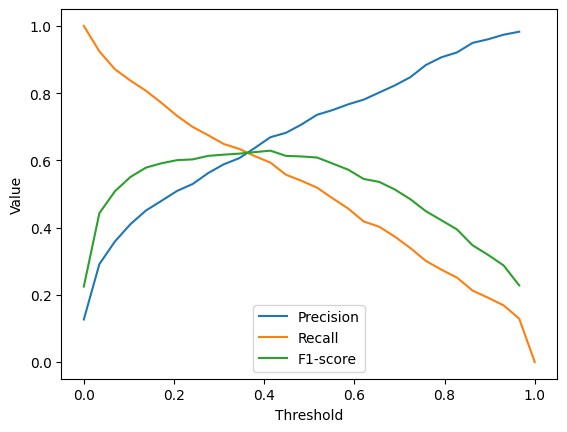

In [30]:
# try different acceptance thresholds for predicted labels and plot precision, recall and f1-score
import matplotlib.pyplot as plt
thresholds = np.linspace(0.0, 1.0, 30)
precision = []
recall = []
f1_score = []
best_f1_score = 0
best_threshold = 0

for threshold in thresholds:
    y_pred = model.predict(X_test)
    y_pred = (y_pred > threshold).astype(int)
    true_positives = np.sum(y_test * y_pred)
    false_positives = np.sum(y_pred) - true_positives
    false_negatives = np.sum(y_test) - true_positives
    precision.append(true_positives / (true_positives + false_positives))
    recall.append(true_positives / (true_positives + false_negatives))
    f1_score.append(2 * precision[-1] * recall[-1] / (precision[-1] + recall[-1]))
    if f1_score[-1] > best_f1_score:
        best_f1_score = f1_score[-1]
        best_threshold = threshold

plt.plot(thresholds, precision, label='Precision')
plt.plot(thresholds, recall, label='Recall')
plt.plot(thresholds, f1_score, label='F1-score')
plt.xlabel('Threshold')
plt.ylabel('Value')
plt.legend()
plt.show()

In [31]:
# show example of image, predicted labels and true labels
import matplotlib.pyplot as plt

def show_example(X, y, label_to_index, index_to_label, index):
    image = X[index]
    labels = y[index]
    predicted_probabilities = model.predict(np.array([image]))[0]

    predicted_labels = [index_to_label[i] for i, value in enumerate(predicted_probabilities) if value > best_threshold]

    if len(predicted_labels) > 5:
        threshold = 0.6
        predicted_labels = [index_to_label[i] for i, value in enumerate(predicted_probabilities) if value > threshold]
        if len(predicted_labels) > 5:
            threshold = 0.7
            predicted_labels = [index_to_label[i] for i, value in enumerate(predicted_probabilities) if value > threshold]
            if len(predicted_labels) > 5:
                threshold = 0.8
                predicted_labels = [index_to_label[i] for i, value in enumerate(predicted_probabilities) if value > threshold]
                if len(predicted_labels) > 5:
                    threshold = 0.95
                    predicted_labels = [index_to_label[i] for i, value in enumerate(predicted_probabilities) if value > threshold]

    true_labels = [index_to_label[i] for i, value in enumerate(labels) if value == 1]

    plt.imshow(image)
    plt.title('Predicted labels: ' + ', '.join(predicted_labels) + '\nTrue labels: ' + ', '.join(true_labels))
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


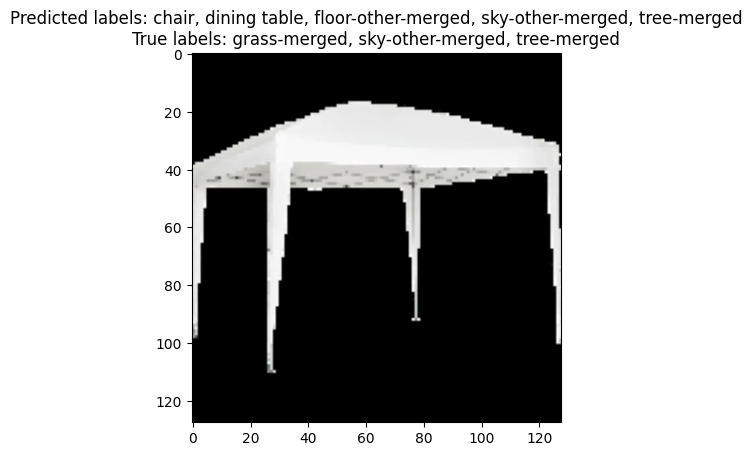

In [32]:
show_example(X_test, y_test, label_to_index, {index: label for label, index in label_to_index.items()}, 0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


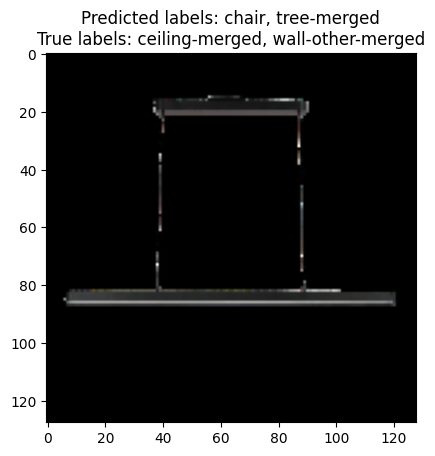

In [33]:
show_example(X_test, y_test, label_to_index, {index: label for label, index in label_to_index.items()}, 100)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


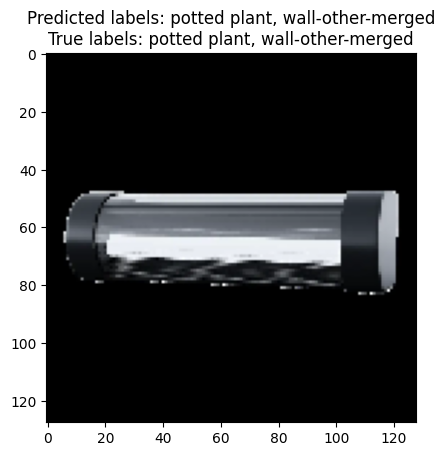

In [34]:
show_example(X_test, y_test, label_to_index, {index: label for label, index in label_to_index.items()}, 80)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


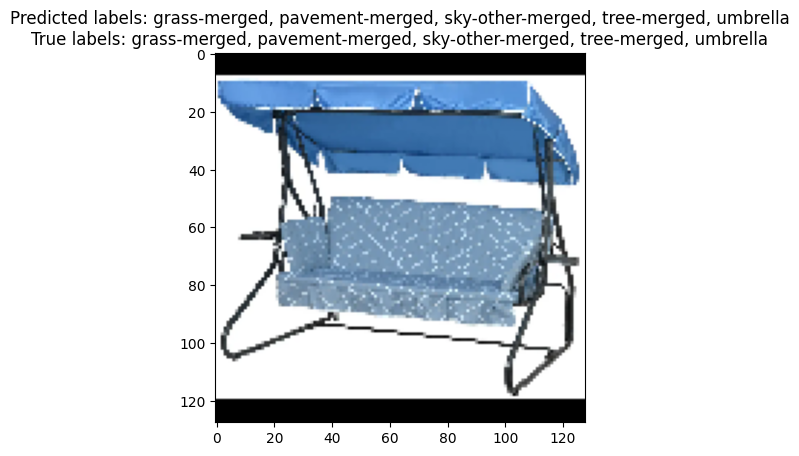

In [35]:
show_example(X_test, y_test, label_to_index, {index: label for label, index in label_to_index.items()}, 50)

In [36]:
# example how to deal with the model
image = load_img('image_test.png', target_size=image_size)
image = img_to_array(image) / 255.0
predicted_labels = model.predict(np.array([image]))[0]
predicted_labels = [index for index, value in enumerate(predicted_labels) if value > best_threshold]
predicted_labels = [label for label, index in label_to_index.items() if index in predicted_labels]
print('Predicted labels:', predicted_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted labels: ['chair', 'cup', 'curtain', 'dining table', 'floor-other-merged', 'light', 'potted plant', 'table-merged', 'tree-merged', 'wall-other-merged', 'window-other']
